# Measuring correlation of different LLM-observed salience scores with human salience

## Notebook Setup

### Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages

sns.set_color_codes()
# sns.set_theme()
sns.set_context("paper")

In [2]:
import re
import json
import itertools
from pathlib import Path
from pprint import pprint
from textwrap import wrap

import krippendorff
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from info_salience.agreement import spearman_rank_correlation
from info_salience import utils

### Utils

In [3]:
rename_model = {
    'OLMo-7B-Instruct-hf': 'OLMo (7B)',
    'OLMo-7B-0724-Instruct-hf': 'OLMo 0724 (7B)',
    'Mistral-7B-Instruct-v0.3': 'Mistral (7B)',
    'Mixtral-8x7B-Instruct-v0.1': 'Mixtral (8x7B)',
    'Llama-2-7b-chat-hf': 'Llama 2 (7B)',
    'Llama-2-13b-chat-hf': 'Llama 2 (13B)',
    'Llama-2-70b-chat-hf': 'Llama 2 (70B)',
    'Meta-Llama-3-8B-Instruct': 'Llama 3 (8B)',
    'Meta-Llama-3-70B-Instruct': 'Llama 3 (70B)',
    'Meta-Llama-3.1-8B-Instruct': 'Llama 3.1 (8B)',
    'Meta-Llama-3.1-70B-Instruct': 'Llama 3.1 (70B)',
    'gpt-4o-mini-2024-07-18': 'GPT-4o-mini (07/24)',
    'gpt-4o-2024-08-06': 'GPT-4o (08/24)'
}

rename_dataset = {
    'pubmed-sample': 'RCT',
    'astro-ph': 'Astro',
    'cs-cl': 'CL',
    'qmsum-generic': 'QMsum',
}

In [4]:
def pairwise_spearman(raters_a, raters_b=None):
    """
    calculates pairwise spearman rank correlation between two pools of raters
    raters_a and raters_b should be of shape (n_raters, n_items)
    """
    if raters_b is None:
        pairs = itertools.combinations(raters_a, r=2)
    else:
        assert raters_a.shape[1] == raters_b.shape[1]
        pairs = itertools.product(raters_a, raters_b)

    scores = []
    for ratings_a, ratings_b in pairs:
        score = spearman_rank_correlation(ratings_a, ratings_b)
        scores.append(score)
    return scores


a = np.array([
    [2, 5, 4, 3, 4, 5, 2, 2, 3, 2, 4, 3, 4, 4],
    [2, 5, 5, 3, 5, 5, 3, 2, 4, 4, 4, 3, 3, 4],
    [2, 5, 4, 4, 5, 4, 2, 1, 3, 1, 5, 2, 3, 4],
    [2, 4, 4, 3, 5, 5, 3, 3, 1, 5, 4, 2, 3, 4],
    [2, 5, 4, 3, 4, 5, 3, 3, 2, 4, 4, 3, 4, 4]
])

b = np.array([
    [2, 3, 5, 2, 5, 5, 4, 3, 1, 3, 4, 4, 4, 5],
    [3, 5, 5, 4, 4, 5, 2, 2, 4, 4, 5, 1, 2, 2],
    [3, 4, 5, 3, 5, 5, 5, 2, 3, 5, 5, 5, 5, 5],
    [1, 5, 4, 2, 5, 3, 1, 4, 1, 4, 5, 3, 2, 4],
    [3, 5, 2, 4, 5, 5, 1, 1, 3, 1, 2, 1, 2, 2]
])


print('n vs m')
scores = pairwise_spearman(a, b)
print('n comparisons:', len(scores))
print('score', round(np.mean(scores), 3))
print()

print('1 vs m')
scores = pairwise_spearman(a[0].reshape(1, -1), b)
print('n comparisons:', len(scores))
print('score', round(np.mean(scores), 3))
print()

print('1 vs 1')
scores = pairwise_spearman(a[0].reshape(1, -1), b[0].reshape(1, -1))
print('n comparisons:', len(scores))
print('score', round(np.mean(scores), 3))
print()

n vs m
n comparisons: 25
score 0.533

1 vs m
n comparisons: 5
score 0.524

1 vs 1
n comparisons: 1
score 0.557



## Load Data

In [ ]:
# run_path = '../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-0.json'
def load_observed_ratings(run_path):
    run_path = Path(run_path)
    if "output" in run_path.name:
        # for baselines (random, lead, textrank)
        match = re.match("output-(\d+).json", run_path.name)
        repeat = match.group(1) if match else 0
    else:
        match = re.match(".*temperature([\d\.]+)-(\d+).json", run_path.name)
        repeat = int(match.group(2))
    rater = run_path.parents[1].name
    dataset = run_path.parents[2].name

    df = pd.read_json(run_path)
    df = df.rename({'cluster_id': 'question_id'}, axis=1)
    variables = ['summary_10w_nli_pred', 'summary_20w_nli_pred', 'summary_50w_nli_pred', 'summary_100w_nli_pred', 'summary_200w_nli_pred']
    df = df.groupby(['doc_id', 'question_id'])[variables].mean().groupby(level=1).mean()

    lengths = np.array([10, 20, 50, 100, 200])
    df['uniform'] = np.average(df[variables], axis=1, weights=np.array([1]*len(lengths)))
    df['reciprocal'] = np.average(df[variables], axis=1, weights=1 / lengths)  # Reciprocal weighting
    df['log'] = np.average(df[variables], axis=1, weights=1 / np.log1p(lengths))  # Logarithmic weighting

    df = df.rename({
        'summary_10w_nli_pred': '10w',
        'summary_20w_nli_pred': '20w',
        'summary_50w_nli_pred': '50w',
        'summary_100w_nli_pred': '100w',
        'summary_200w_nli_pred': '200w',
    }, axis=1)
    df = df.reset_index().melt(id_vars='question_id', var_name='variant', value_name='rating')
    df['rater'] = rater
    df['dataset'] = dataset
    df['repeat'] = repeat
    df = df[['dataset', 'rater', 'variant', 'repeat', 'question_id', 'rating']]
    return df



def load_all_ratings_observed_salience():
    runs = []
    for dataset in ['pubmed-sample', 'cs-cl', 'astro-ph', 'qmsum-generic']:
        # get models in this dataset with temperature 0.3
        paths = list(Path(f'../output/{dataset}/').glob('**/discord-qa-nli/temperature0.3-*.json'))
        paths += list(Path(f'../output/{dataset}/').glob('**/discord-qa-nli/output*.json'))
        for p in paths:
            model = p.parents[1].name
            runs.append((dataset, model, p))
    df_runs = pd.DataFrame(runs, columns=['dataset', 'model', 'run'])
    df_runs = df_runs[~df_runs['model'].str.contains('quantized')]

    dfs = []
    for index, row in tqdm(df_runs.iterrows(), total=len(df_runs)):
        df_model_ratings = load_observed_ratings(row['run'])
        dfs.append(df_model_ratings)

    df_ratings_llm_length = pd.concat(dfs, ignore_index=True)
    return df_ratings_llm_length

In [6]:
df_llm_observed = load_all_ratings_observed_salience()

  0%|          | 0/254 [00:00<?, ?it/s]

In [ ]:
def load_human_ratings():
    items = []

    for json_file in Path('../data/annotations/human-salience/').glob('*.json'):
        print('Loading:', json_file)

        with open(json_file) as fin:
            data = json.load(fin)

        for item in data['items']:
            items.append({
                'dataset': data['dataset'],
                'rater': data['annotator'],
                'repeat': 0,  # to align with other analysis where we sometimes have multiple ratings for the same rater
                'variant': 0,  # to align with other analysis where we sometimes have multiple ratings for the same rater
                'question_id': item['id'],
                'rating': item['rating'],
                'rationale': item['rationale']
            })

    df_ratings = pd.DataFrame(items)
    return df_ratings

In [8]:
df_humans = load_human_ratings()
df_humans.head()

Loading: ../data/annotations/human-salience/astro-ph-1dre2sz.json
Loading: ../data/annotations/human-salience/cs-cl-fd6d95de.json
Loading: ../data/annotations/human-salience/astro-ph-fgmyyll.json
Loading: ../data/annotations/human-salience/qmsum-generic-06r6zhf.json
Loading: ../data/annotations/human-salience/cs-cl-ihvb1io.json
Loading: ../data/annotations/human-salience/pubmed-sample-1gxc5yr.json
Loading: ../data/annotations/human-salience/pubmed-sample-a4pjhcl.json
Loading: ../data/annotations/human-salience/cs-cl-m0vrw0r.json
Loading: ../data/annotations/human-salience/qmsum-generic-qcpmyok.json
Loading: ../data/annotations/human-salience/astro-ph-t39hhaf.json
Loading: ../data/annotations/human-salience/cs-cl-06r6zhf.json
Loading: ../data/annotations/human-salience/astro-ph-22ed0lh.json
Loading: ../data/annotations/human-salience/qmsum-generic-kol9cy5.json
Loading: ../data/annotations/human-salience/pubmed-sample-j42q3qe.json
Loading: ../data/annotations/human-salience/astro-ph-54zn

,dataset,rater,repeat,variant,question_id,rating,rationale
0,astro-ph,1dre2sz,0,0,3,1,Based on the provided examples I most likely d...
1,astro-ph,1dre2sz,0,0,9,1,"The future direction, IMO, should not be inclu..."
2,astro-ph,1dre2sz,0,0,12,2,"In some cases, we describe the technique or mo..."
3,astro-ph,1dre2sz,0,0,2,4,I think interpretation and implications of the...
4,astro-ph,1dre2sz,0,0,6,3,Comparison in this context can have three mean...


In [9]:
df_ratings = pd.concat([
    df_llm_observed.assign(group='llm_observed'),
    df_humans.assign(group='humans'),
])
df_ratings.head()

,dataset,rater,variant,repeat,question_id,rating,group,rationale
0,pubmed-sample,gpt-4o-mini-2024-07-18,10w,1,0,0.064295,llm_observed,NaN
1,pubmed-sample,gpt-4o-mini-2024-07-18,10w,1,1,0.311264,llm_observed,NaN
2,pubmed-sample,gpt-4o-mini-2024-07-18,10w,1,2,0.051537,llm_observed,NaN
3,pubmed-sample,gpt-4o-mini-2024-07-18,10w,1,3,0.032040,llm_observed,NaN
4,pubmed-sample,gpt-4o-mini-2024-07-18,10w,1,4,0.120155,llm_observed,NaN


## Calculate correlation

In [ ]:
def llm_observed_vs_human(dataset, rater, variant, debug=False):
    ratings_human =  df_ratings[(df_ratings['dataset'] == dataset) & (df_ratings['group'] == 'humans')].pivot(index='rater', columns='question_id', values='rating')
    ratings_model = df_ratings[
        (df_ratings['dataset'] == dataset)
        & (df_ratings['group'] == 'llm_observed')
        & (df_ratings['rater'] == rater)
        & (df_ratings['variant'] == variant)
    ].pivot(index=['rater', 'repeat'], columns='question_id', values='rating')

    if ratings_model.empty:
        return None

    if debug:
        display(ratings_model)
        display(ratings_human)

    scores = pairwise_spearman(ratings_human.values, ratings_model.values)
    return scores

In [11]:
np.mean(llm_observed_vs_human('pubmed-sample', 'gpt-4o-2024-08-06', '200w', debug=True))

question_id                     0         1         2         3         4   \
rater             repeat                                                     
gpt-4o-2024-08-06 0       0.788991  0.943478  0.541979  0.721512  0.848677   
                  1       0.772155  0.951690  0.533730  0.658880  0.844650   
                  2       0.788108  0.941984  0.547400  0.666351  0.836063   
                  3       0.810974  0.956980  0.535564  0.701817  0.845303   
                  4       0.775815  0.949968  0.560358  0.672505  0.833051   

question_id                     6         8         9         10        11  \
rater             repeat                                                     
gpt-4o-2024-08-06 0       0.766436  0.774925  0.880896  0.885802  0.881931   
                  1       0.773754  0.755373  0.889398  0.888895  0.882953   
                  2       0.748403  0.768360  0.874857  0.870259  0.882503   
                  3       0.768318  0.761119  0.897561  0.879488  0.889894   
                  4       0.759711  0.751315  0.879646  0.870897  0.869954   

question_id               ...        18        19        20        23  \
rater             repeat  ...                                           
gpt-4o-2024-08-06 0       ...  0.746535  0.817810  0.803854  0.825829   
                  1       ...  0.738934  0.823005  0.799576  0.810538   
                  2       ...  0.738724  0.821573  0.800175  0.815721   
                  3       ...  0.747645  0.819003  0.814140  0.827059   
                  4       ...  0.732933  0.814499  0.803552  0.822799   

question_id                     26        28        29        31        34  \
rater             repeat                                                     
gpt-4o-2024-08-06 0       0.695274  0.756724  0.910950  0.868494  0.890191   
                  1       0.688814  0.761184  0.922173  0.866601  0.887407   
                  2       0.700753  0.751603  0.923528  0.865443  0.886677   
                  3       0.690951  0.780750  0.915697  0.871309  0.897782   
                  4       0.671038  0.762310  0.911280  0.865475  0.880743   

question_id                     36  
rater             repeat            
gpt-4o-2024-08-06 0       0.868764  
                  1       0.871524  
                  2       0.869007  
                  3       0.870954  
                  4       0.864116  

[5 rows x 21 columns]

question_id,0,1,2,3,4,6,8,9,10,11,...,18,19,20,23,26,28,29,31,34,36
rater,,,,,,,,,,,,,,,,,,,,,
1gxc5yr,4.0,5.0,3.0,2.0,5.0,3.0,5.0,5.0,3.0,2.0,...,3.0,2.0,2.0,3.0,5.0,3.0,5.0,5.0,3.0,5.0
a4pjhcl,2.0,5.0,1.0,2.0,3.0,1.0,5.0,4.0,5.0,5.0,...,5.0,1.0,4.0,1.0,5.0,1.0,5.0,4.0,4.0,5.0
j42q3qe,3.0,4.0,3.0,4.0,3.0,4.0,5.0,5.0,5.0,4.0,...,3.0,4.0,4.0,4.0,5.0,3.0,5.0,4.0,5.0,5.0


0.24345233842248445

In [12]:
filtered = df_ratings[(df_ratings['group'] == 'llm_observed')]
datasets = filtered['dataset'].unique()
raters = filtered['rater'].unique()
variants = filtered['variant'].unique()

stats = []
for dataset, rater, variant in itertools.product(datasets, raters, variants):
    scores = llm_observed_vs_human(dataset, rater, variant)

    if not scores:
        print(f'n/a:', (dataset, rater))
        continue
    else:
        stats.append({
            'dataset': dataset,
            'rater': rater,
            'variant': variant,
            'mean': np.mean(scores),
            'std': np.std(scores),
            'raw': scores
        })

df_llm_observed_vs_human = pd.DataFrame(stats)
df_llm_observed_vs_human.head()

n/a: ('qmsum-generic', 'Meta-Llama-3-8B-Instruct')
n/a: ('qmsum-generic', 'Meta-Llama-3-8B-Instruct')
n/a: ('qmsum-generic', 'Meta-Llama-3-8B-Instruct')
n/a: ('qmsum-generic', 'Meta-Llama-3-8B-Instruct')
n/a: ('qmsum-generic', 'Meta-Llama-3-8B-Instruct')
n/a: ('qmsum-generic', 'Meta-Llama-3-8B-Instruct')
n/a: ('qmsum-generic', 'Meta-Llama-3-8B-Instruct')
n/a: ('qmsum-generic', 'Meta-Llama-3-8B-Instruct')
n/a: ('qmsum-generic', 'Llama-2-13b-chat-hf')
n/a: ('qmsum-generic', 'Llama-2-13b-chat-hf')
n/a: ('qmsum-generic', 'Llama-2-13b-chat-hf')
n/a: ('qmsum-generic', 'Llama-2-13b-chat-hf')
n/a: ('qmsum-generic', 'Llama-2-13b-chat-hf')
n/a: ('qmsum-generic', 'Llama-2-13b-chat-hf')
n/a: ('qmsum-generic', 'Llama-2-13b-chat-hf')
n/a: ('qmsum-generic', 'Llama-2-13b-chat-hf')
n/a: ('qmsum-generic', 'Meta-Llama-3-70B-Instruct')
n/a: ('qmsum-generic', 'Meta-Llama-3-70B-Instruct')
n/a: ('qmsum-generic', 'Meta-Llama-3-70B-Instruct')
n/a: ('qmsum-generic', 'Meta-Llama-3-70B-Instruct')
n/a: ('qmsum-gen

,dataset,rater,variant,mean,std,raw
0,pubmed-sample,gpt-4o-mini-2024-07-18,10w,0.291509,0.140756,"[0.4620393193409229, 0.4695577106319734, 0.435..."
1,pubmed-sample,gpt-4o-mini-2024-07-18,20w,0.254238,0.135980,"[0.4148785012425151, 0.4558879082846088, 0.433..."
2,pubmed-sample,gpt-4o-mini-2024-07-18,50w,0.217931,0.100032,"[0.3390110982146416, 0.31440545398938535, 0.32..."
3,pubmed-sample,gpt-4o-mini-2024-07-18,100w,0.292030,0.088785,"[0.2399050311962484, 0.21393240673625571, 0.22..."
4,pubmed-sample,gpt-4o-mini-2024-07-18,200w,0.336514,0.067423,"[0.25630879401308587, 0.2453729521351942, 0.27..."


In [13]:
raters_filtered = [
    'gpt-4o-mini-2024-07-18',
    'Mixtral-8x7B-Instruct-v0.1',
    'Meta-Llama-3-8B-Instruct',
    'Llama-2-13b-chat-hf',
    'Meta-Llama-3-70B-Instruct',
    'Meta-Llama-3.1-8B-Instruct',
    'Meta-Llama-3.1-70B-Instruct',
    'Llama-2-70b-chat-hf',
    'OLMo-7B-Instruct-hf',
    'Llama-2-7b-chat-hf',
    'Mistral-7B-Instruct-v0.3',
    'OLMo-7B-0724-Instruct-hf',
    'gpt-4o-2024-08-06',
]

rename_dataset = {
    'pubmed-sample': 'RCT',
    'astro-ph': 'Astro',
    'cs-cl': 'CL',
    'qmsum-generic': 'QMSum',
}

In [14]:
import matplotlib.ticker as ticker

,dataset,rater,variant,mean,std,raw
0,RCT,gpt-4o-mini-2024-07-18,10w,0.291509,0.140756,0.462039
0,RCT,gpt-4o-mini-2024-07-18,10w,0.291509,0.140756,0.469558
0,RCT,gpt-4o-mini-2024-07-18,10w,0.291509,0.140756,0.435383
0,RCT,gpt-4o-mini-2024-07-18,10w,0.291509,0.140756,0.492796
0,RCT,gpt-4o-mini-2024-07-18,10w,0.291509,0.140756,0.427865


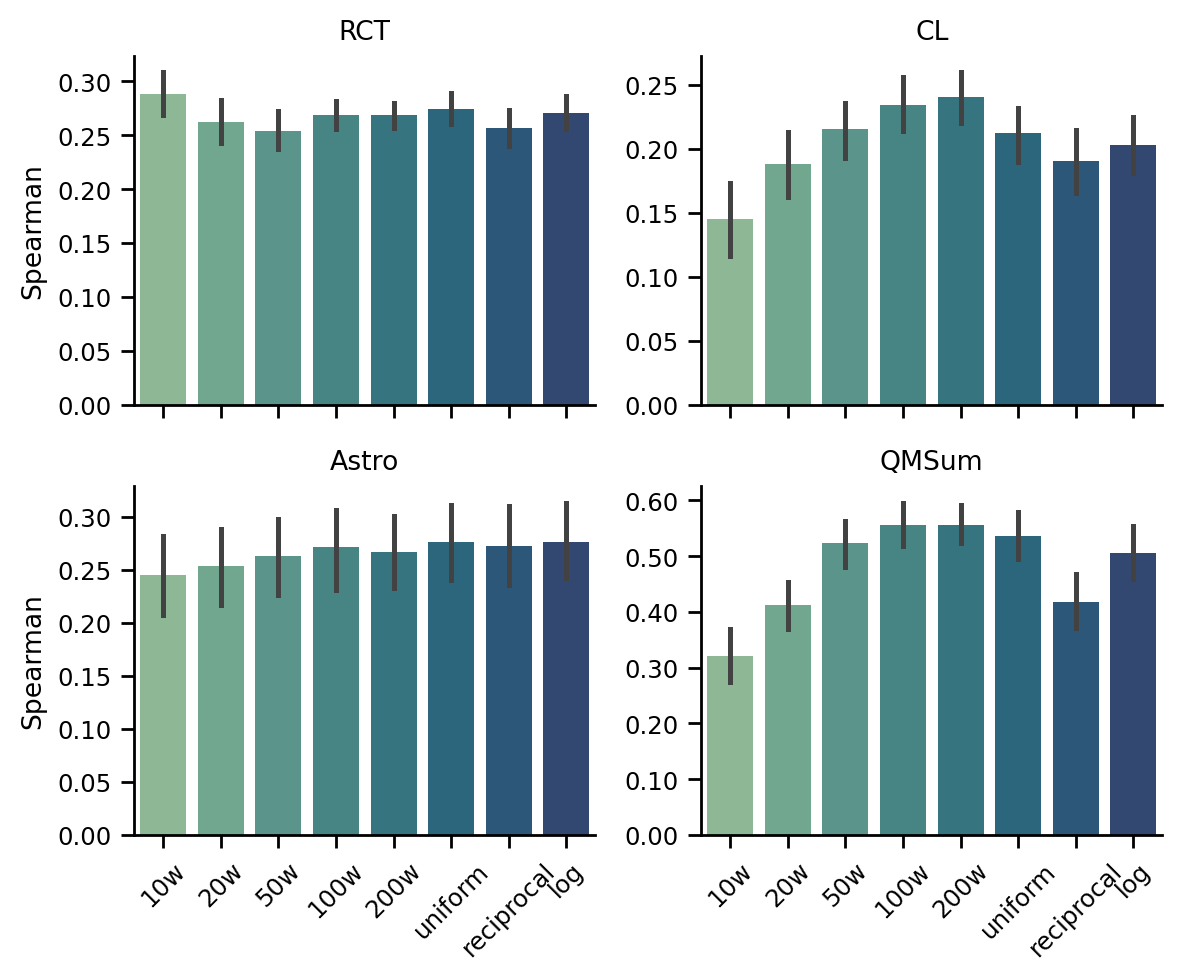

In [16]:
df_plot = df_llm_observed_vs_human[df_llm_observed_vs_human['rater'].isin(raters_filtered)].explode('raw')
df_plot['dataset'] = df_plot['dataset'].apply(rename_dataset.get)

display(df_plot.head())

g = sns.catplot(
    df_plot,
    x='variant',
    y='raw',
    col='dataset',
    hue='variant',
    # row='rater',
    kind='bar',
    sharex=True,
    # cut=0,
    sharey=False,
    palette='crest',
    col_wrap=2,
    height=2.5,
    aspect=1.2,
)
g.set_ylabels('Spearman')
g.set_xlabels('')
g.set_titles(col_template='{col_name}')
g.tick_params(rotation=45, axis='x');

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))

plt.tight_layout()
utils.savefig(g.fig, 'salience-score-correlation', formats=['pdf'], path='../output/figures-paper/')